In [17]:
# Import the required library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
""" Create an method to read the csv file with the seperation process
    fp : File path
"""
def read_dataFile(fp):
    # Read the file 
    file = open(fp,"r", encoding ="utf-8" )
    # Get read each of lines in the csv file
    lines = file.readlines()
    # Get the first line to seperate each name in columns 
    first_line = lines.pop(0)
    # Clean the empty space by strip(); And replace the "" on column names and seperate names by ";"
    col_names = first_line.strip().replace('"', '').split(';')
    # Deal with the left lines
    data = []
    # Iterate each line to process the data which is only seperate by the ";"
    for line in lines:
        tmp_l = line.strip().split(';') # tmp_l is temperal line
        data.append(tmp_l)
    # Form a data frame for future processing
    df = pd.DataFrame(data, columns=col_names)
    # Check the dataframe (first five lines)
    print(df.head())
    return df
# 

In [3]:
# method to deal with current data frame
original_data = read_dataFile("winequality-red-4.csv")
# We copy the original data into a variable for the following process
wine_data = original_data.copy()

  fixed acidity volatile acidity citric acid residual sugar chlorides  \
0           7.4              0.7           0            1.9     0.076   
1           7.8             0.88           0            2.6     0.098   
2           7.8             0.76        0.04            2.3     0.092   
3          11.2             0.28        0.56            1.9     0.075   
4           7.4              0.7           0            1.9     0.076   

  free sulfur dioxide total sulfur dioxide density    pH sulphates alcohol  \
0                  11                   34  0.9978  3.51      0.56     9.4   
1                  25                   67  0.9968   3.2      0.68     9.8   
2                  15                   54   0.997  3.26      0.65     9.8   
3                  17                   60   0.998  3.16      0.58     9.8   
4                  11                   34  0.9978  3.51      0.56     9.4   

  quality  
0       5  
1       5  
2       5  
3       6  
4       5  


In [7]:
"""
Check whether this data frame missing some values in some columns
"""
def check_missing_value(df):
    # Display the info of this dataframe
    # In this displacement, there is no missing value because of the 1599 entries, 
    # However, the Dtype displacement shows objects that means there may exist some error for data type
    df.info()
    # We plan to convert the all data into a numeric type
    for r in df.columns:
        df[r] = pd.to_numeric(df[r], errors='coerce')
    # After the transformation, the result we get
    print("\nAfter modification: ")
    print(df.info())
    print('\nNumber of Missing Values: ')
    print(df.isnull().sum())
    print(df.head())

    return df



In [9]:
# Apply the missing value method
wine_data = check_missing_value(wine_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed acidity         1599 non-null   object
 1   volatile acidity      1599 non-null   object
 2   citric acid           1599 non-null   object
 3   residual sugar        1599 non-null   object
 4   chlorides             1599 non-null   object
 5   free sulfur dioxide   1599 non-null   object
 6   total sulfur dioxide  1599 non-null   object
 7   density               1599 non-null   object
 8   pH                    1599 non-null   object
 9   sulphates             1599 non-null   object
 10  alcohol               1599 non-null   object
 11  quality               1599 non-null   object
dtypes: object(12)
memory usage: 150.0+ KB

After modification: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column          

In [11]:
"Third Step: This method will focus on outlier data, we will plot the picture first, then we will replace the outlier values with the IQR data"
def outlier_procedure(df):
    # We have to plot all attributes first to observe distribution
    digital_part = df.columns[:-1]

    # Set the figures
    plt.figure(figsize=(20, 24))

    # Plot every feature with histogram 
    for i, variable in enumerate(digital_part):
        # Create the subplot
        plt.subplot(4, 3, i + 1)
        # Create the histogram for each feature
        sns.histplot(df[variable].astype(float), bins=30, color='skyblue', edgecolor='black', linewidth=2, label='Data', alpha=0.5, kde= True)
        # Add the title to each 
        plt.title(f'Distribution of {variable}')
        # Add the x-axis label
        plt.xlabel(variable)
        # Add the y axis label
        plt.ylabel('Frequency')
        plt.legend()
        
    # Display the boxplot to observe the outlier first, then we will decide which method to delete the outlier in the dataset.
    # Set the figure size
    plt.figure(figsize=(20, 24))
    for i, variable in enumerate(digital_part):
        plt.subplot(4, 3, i + 1)
        # Mark the outlier in red
        flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
        sns.boxplot(y=df[variable].astype(float), color= 'skyblue', orient='h',flierprops= flierprops)
        plt.title(f'Boxplot of {variable}')
        plt.ylabel(variable)
    
 
        
    # We apply the IQR method to deal with outlier. IQR is a statistical method to detect and deal with outliers in various distributions, especially for right skewness or left skewness data set.
    """
    The lower bound = Q1 - 1.5 * IQR
    The upper bound = Q3 + 1.5 * IQR
    If the data exceed the lower bound or the upper bound, this data is a outlier. 
    """

    df_copy = df.copy() # Copy a dataframe for current work. Keep the original data for other goals.     

    # Get all volume names and convert to list
    volume_names = df_copy.columns.tolist()
    # We iterate each feature and replace the outlier with reasonable 
    for variable in volume_names:
        # Calculate the Q1 and Q3 
        Q1 = df_copy[variable].quantile(0.75)
        Q3 = df_copy[variable].quantile(0.25)
        # This is the formula to get the IQR
        IQR = Q3 - Q1
        # Calculate the lower bound and upper bound
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # If the outlier exists, we replace the number between 2 bound 
        df_copy[variable] = np.clip(df_copy[variable],lower_bound, upper_bound)
    # This part use the updated dataframe
    digital_part2 = df_copy.columns[:-1]

    # This box plot will display the dataframe with no outlier.
    plt.figure(figsize=(20, 24))
    for i, variable in enumerate(digital_part2):
        plt.subplot(4, 3, i + 1)
        # Mark the outlier in red
        flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
        sns.boxplot(y=df_copy[variable].astype(float), color= 'skyblue', orient='h',flierprops= flierprops)
        plt.title(f'Boxplot of {variable}')
        plt.ylabel(variable)
        
    return df_copy
        


D:\anaconda\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
D:\anaconda\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
D:\anaconda\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
D:\anaconda\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
D:\anaconda\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
D:\anaconda\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal ori

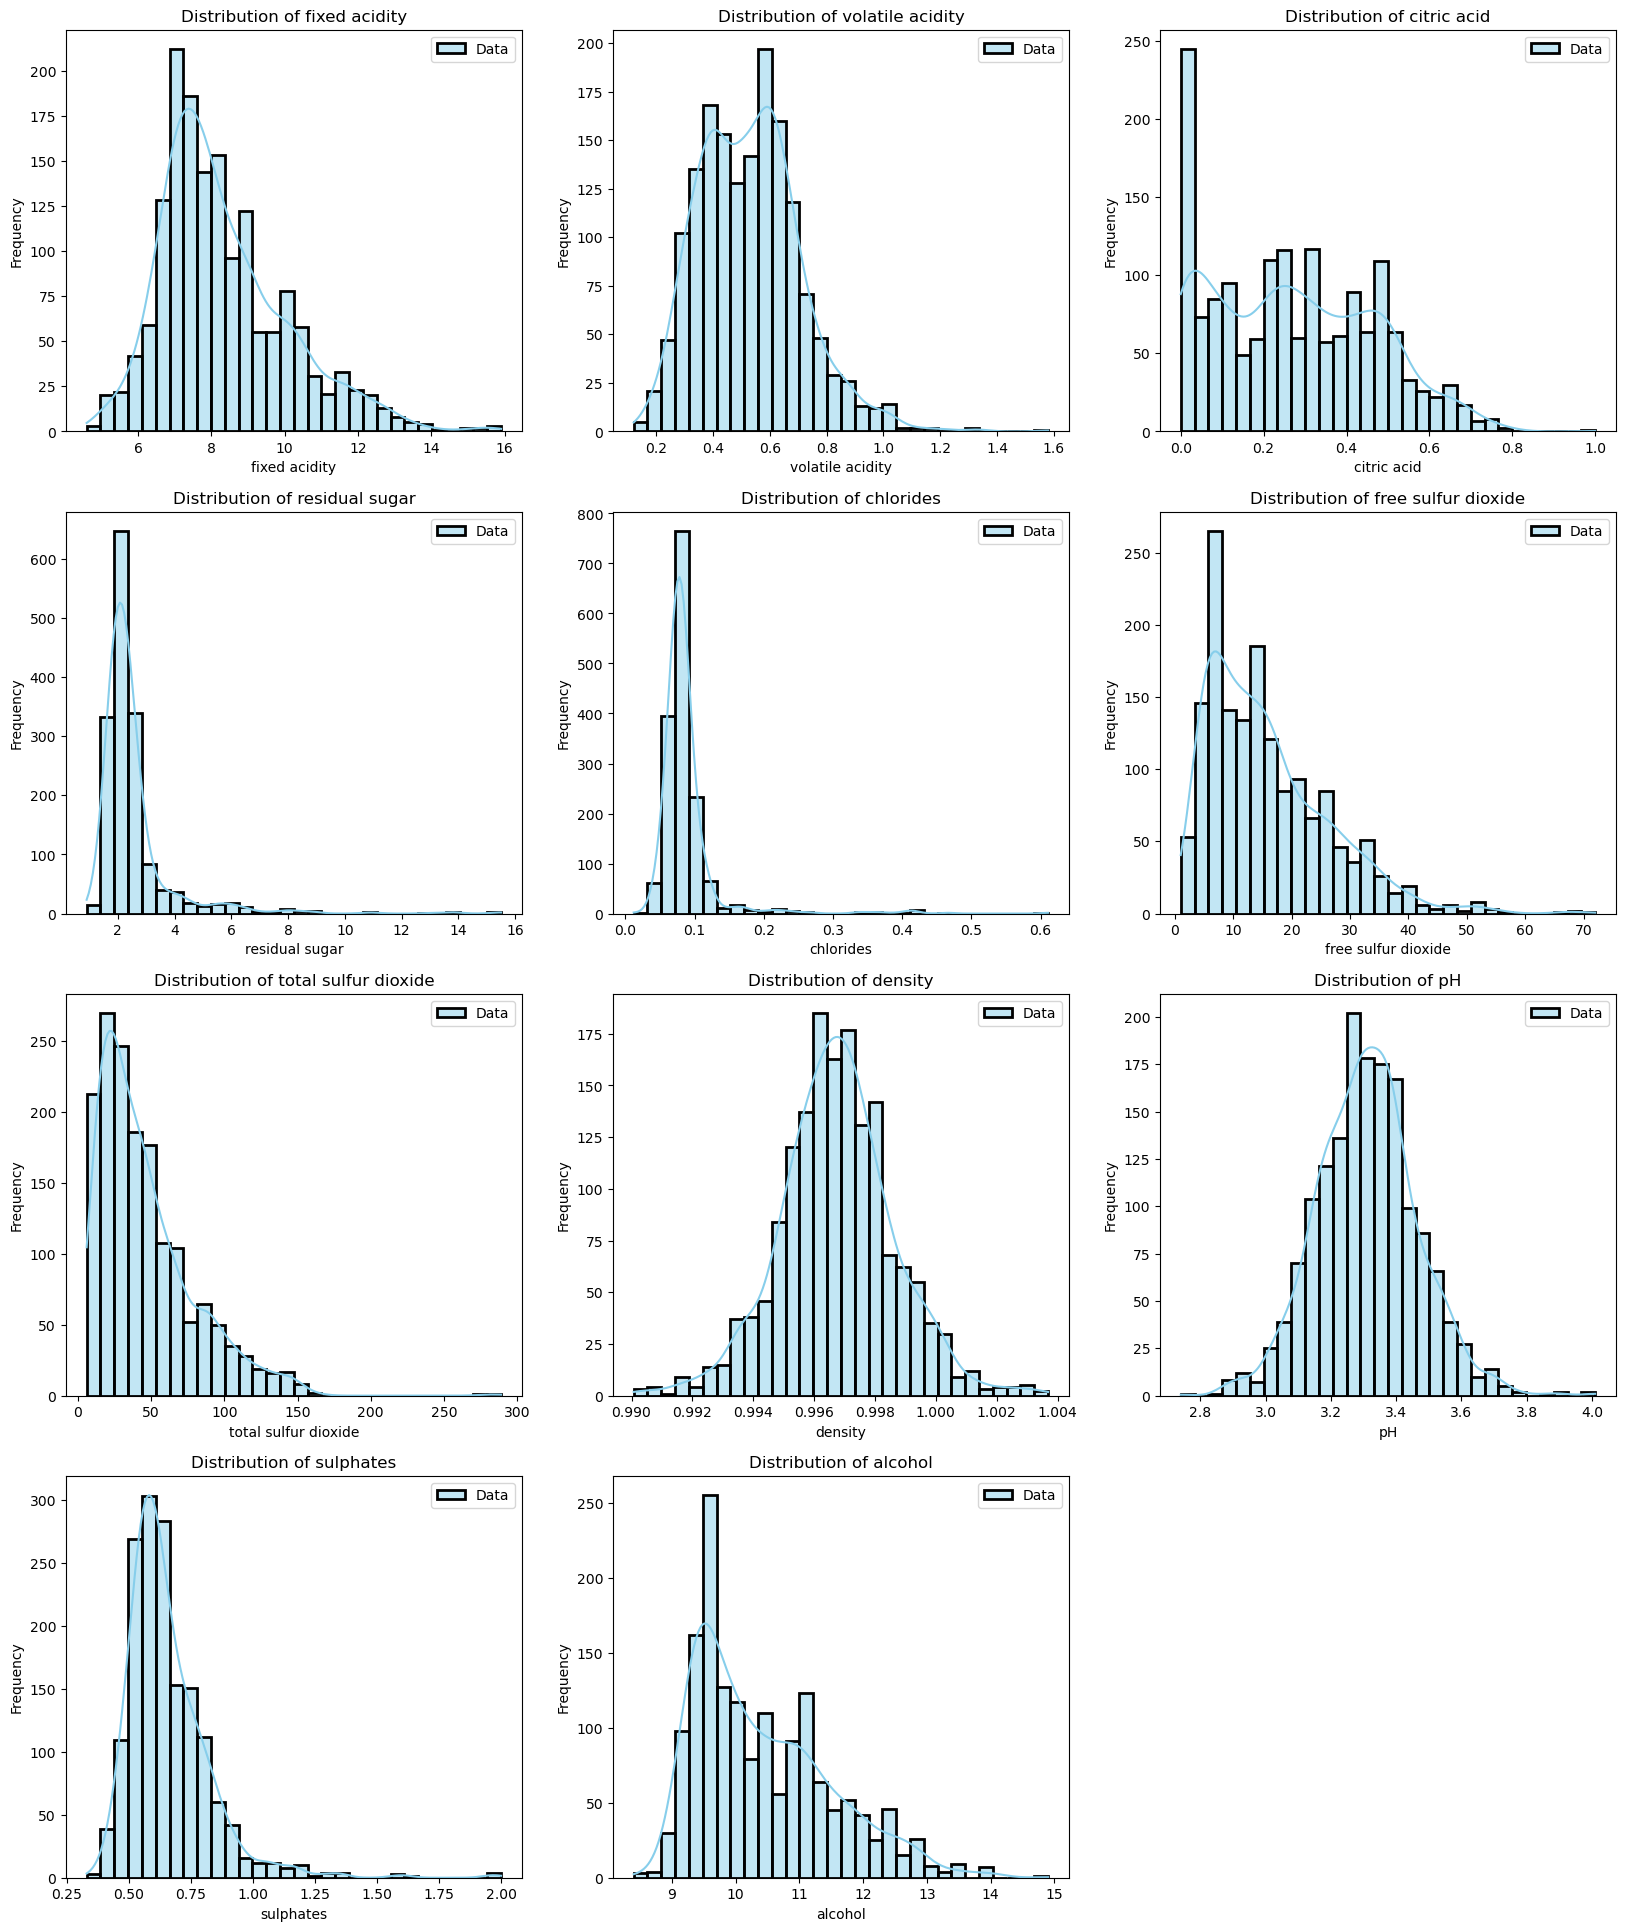

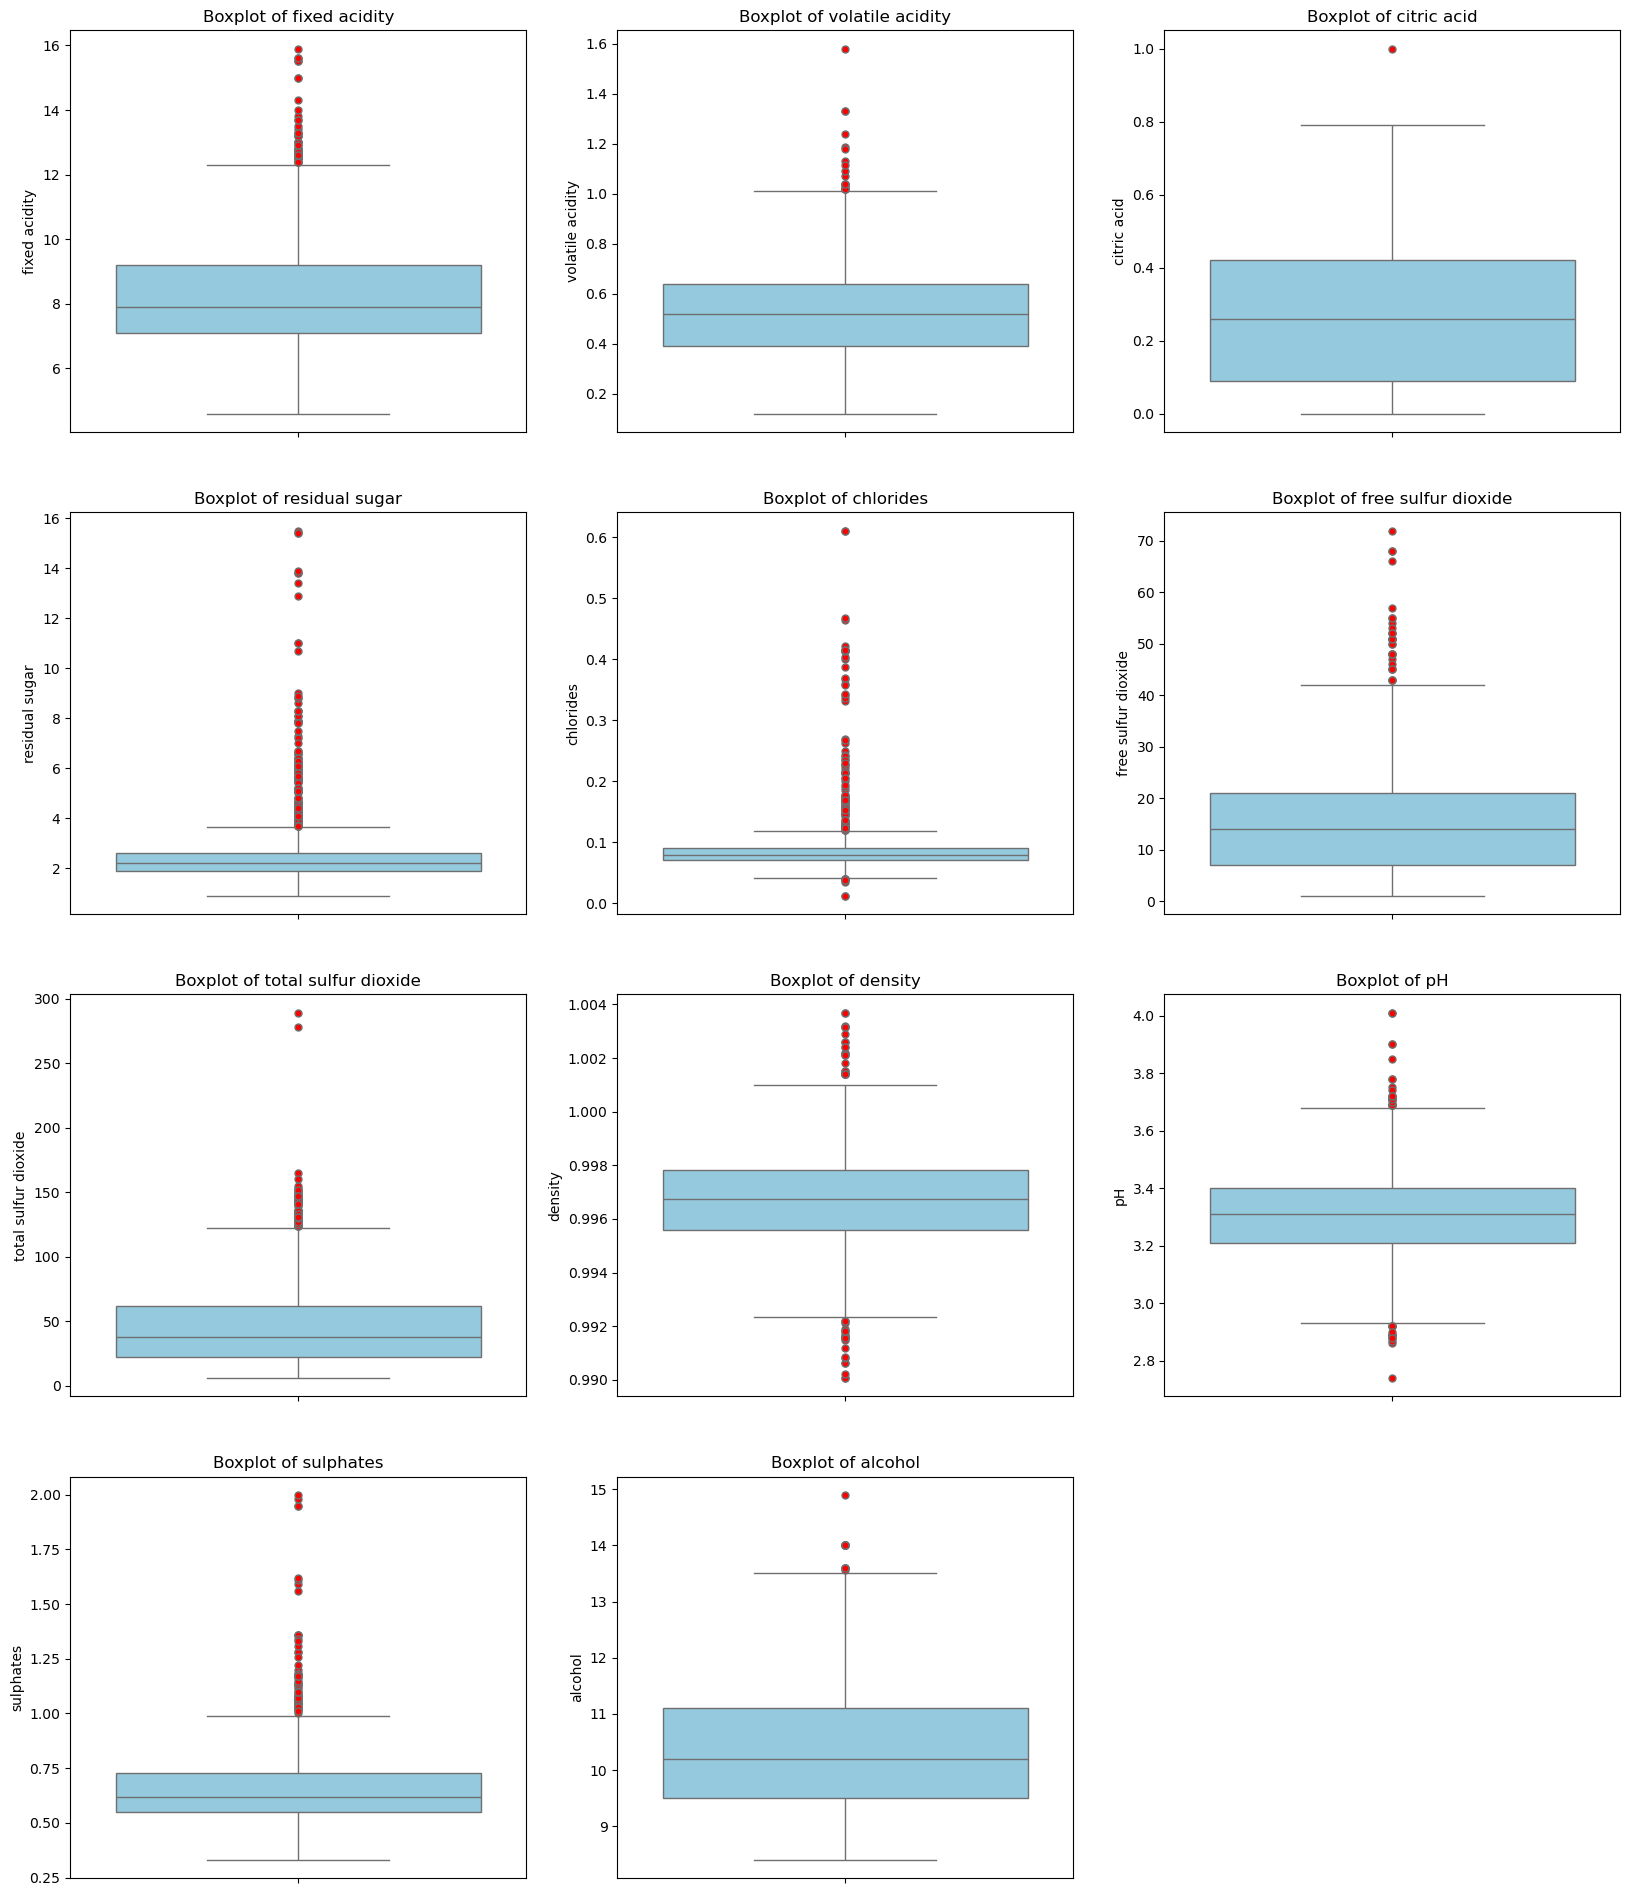

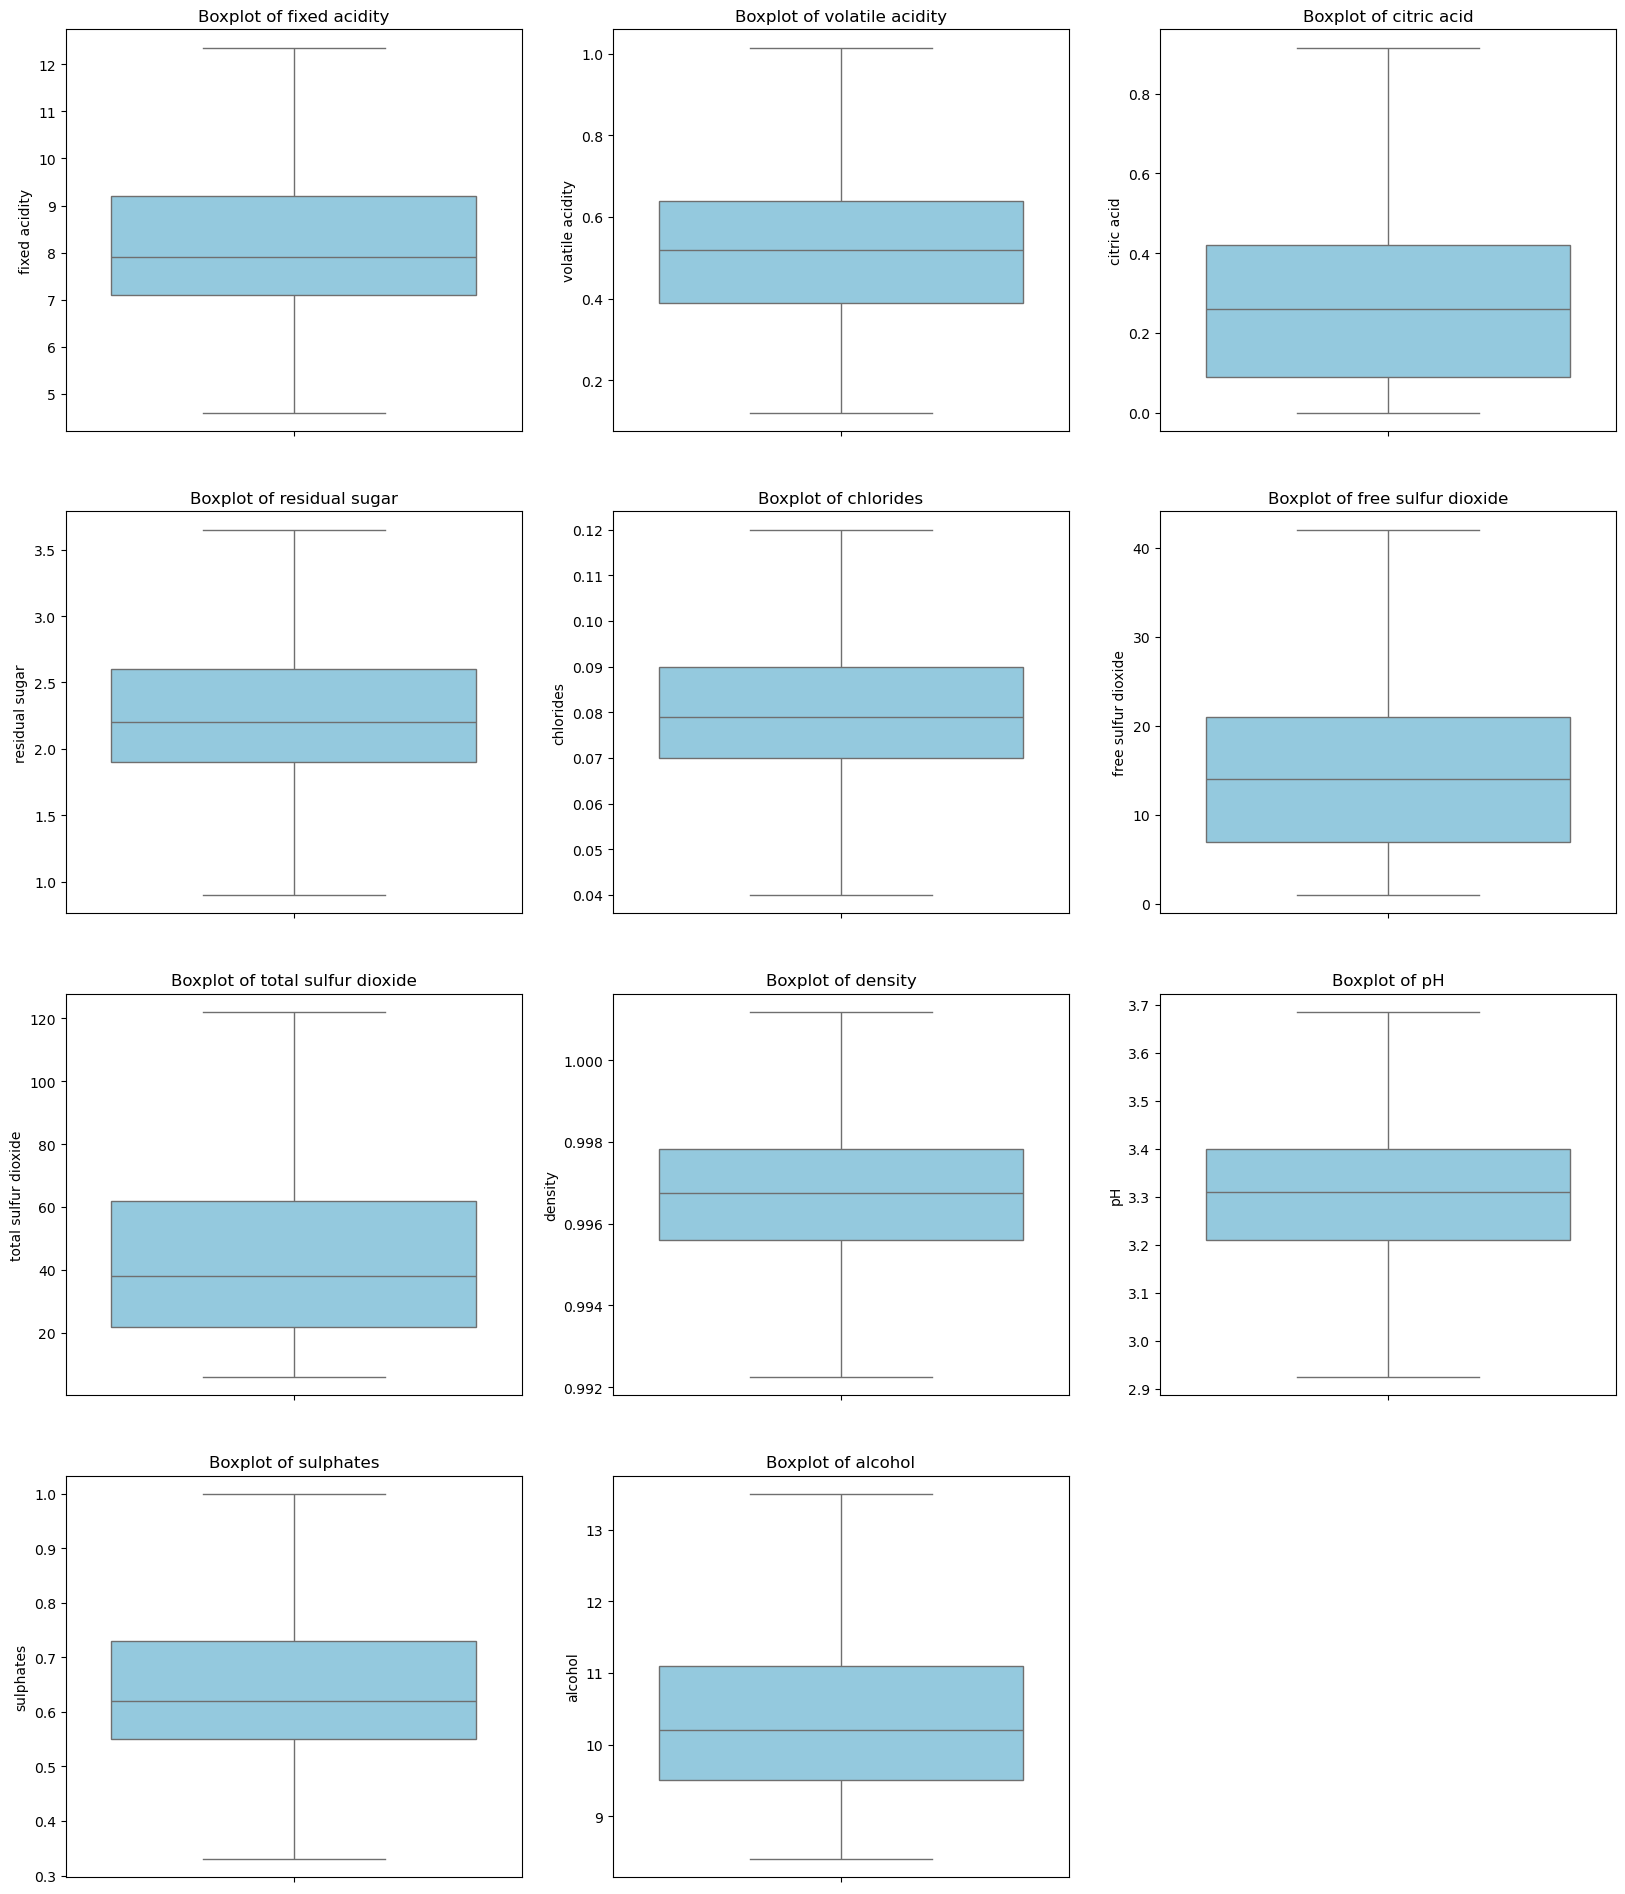

In [13]:
"""
Apply the the outlier procedure
"""
wine_data = outlier_procedure(wine_data)

<Axes: >

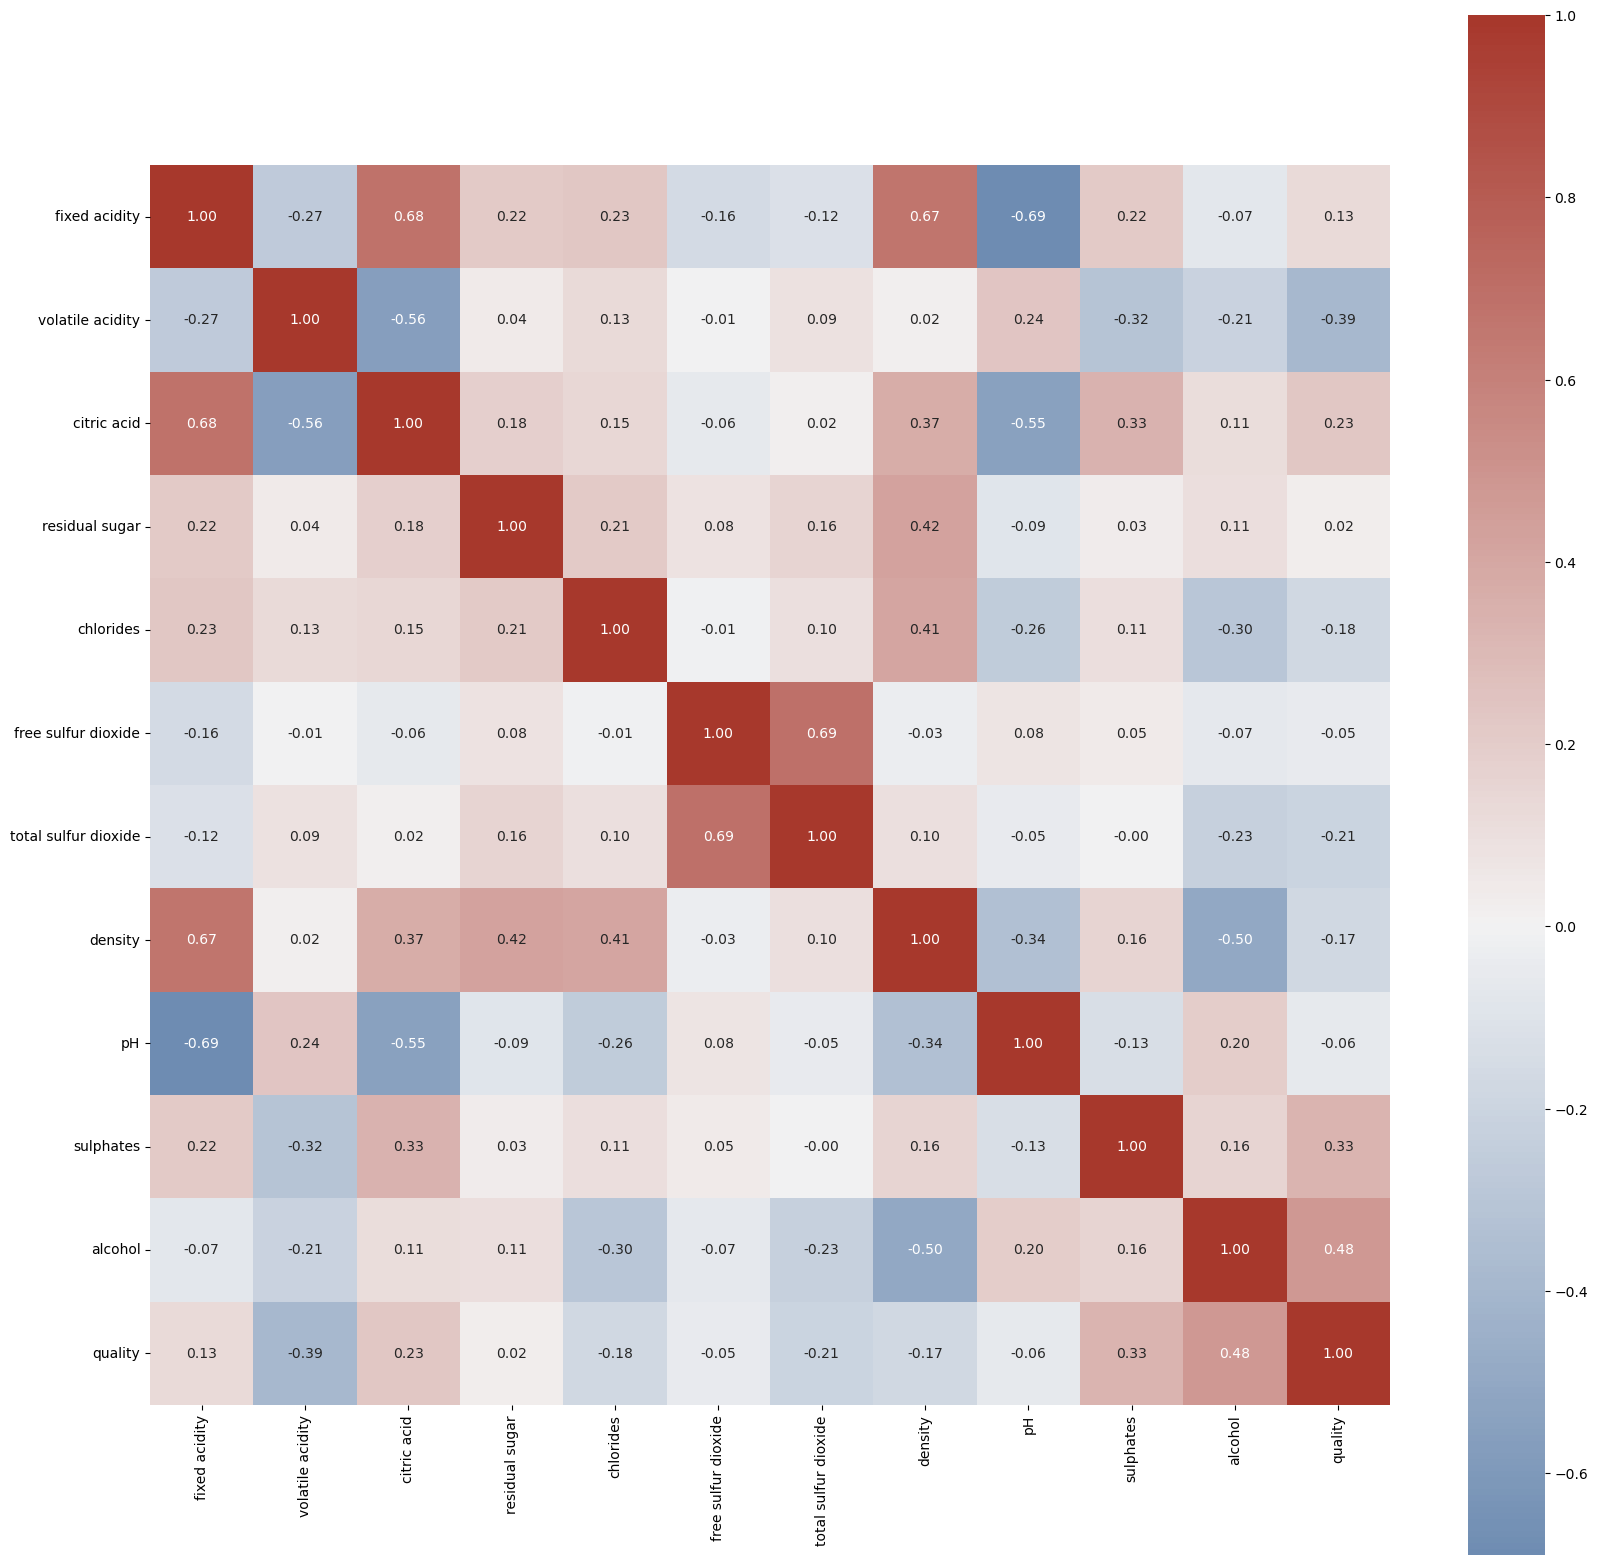

In [21]:
# covariance matrix
cov_matrix=wine_data.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
plt.figure(figsize=(20,20))
sns.heatmap(cov_matrix,  center=0, annot=True,fmt='.2f', square=True, cmap=cmap)

# 